In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

In [2]:
# Load datasets
clean_path = '4000_0.05_clean.csv'
dirty_path = '4000_0.05_dirty.csv'

clean_df = pd.read_csv(clean_path)
dirty_df = pd.read_csv(dirty_path)

# Display basic info about the datasets
# print('Clean Data Info:')
# print(clean_df.info())
# print('\nDirty Data Info:')
# print(dirty_df.info())

# Check the first few rows of the datasets
# print('\nClean Data Sample:')
# print(clean_df.head())
# print('\nDirty Data Sample:')
# print(dirty_df.head())

In [3]:
# Prepare Data: target variable y is the binary classification of NATIVITY (whether a person is Native or Foreign-born)
# The sensitive attribute RAC1P (likely race or ethnicity) is separated out to evaluate fairness
def prepare_data(df, is_clean=True):
    if is_clean:
        df = df.iloc[:, :-8] # Dropping the last 8 columns of the clean dataset
    X = df.drop(['NATIVITY', 'RAC1P'], axis=1)
    y = (df['NATIVITY'] == 1).astype(int) # Binary classification: 1 if Native, 0 if Foreign-born
    sensitive_attr = df['RAC1P']
    X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive_attr, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, s_train, s_test

In [4]:
# Prepare training and testing sets: data is split into training and testing sets, along with the sensitive attribute.
X_train_clean, X_test_clean, y_train_clean, y_test_clean, s_train_clean, s_test_clean = prepare_data(clean_df, is_clean=True)
X_train_dirty, X_test_dirty, y_train_dirty, y_test_dirty, s_train_dirty, s_test_dirty = prepare_data(dirty_df, is_clean=False)

In [5]:
# Fairness Metrics
def demographic_parity(y_pred, sensitive_attr): # Measures whether the prediction rates are equal across different race groups
    groups = sensitive_attr.unique()
    rates = {group: (y_pred[sensitive_attr == group].mean()) for group in groups}
    return rates

def equalized_odds(y_true, y_pred, sensitive_attr): # Measures whether true positive rates and false positive rates are equal across race groups
    groups = sensitive_attr.unique()
    true_positive_rates = {}
    false_positive_rates = {}

    for group in groups:
        y_true_group = y_true[sensitive_attr == group]
        y_pred_group = y_pred[sensitive_attr == group]
        
        tp = ((y_pred_group == 1) & (y_true_group == 1)).sum()
        tn = ((y_pred_group == 0) & (y_true_group == 0)).sum()
        fp = ((y_pred_group == 1) & (y_true_group == 0)).sum()
        fn = ((y_pred_group == 0) & (y_true_group == 1)).sum()
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        true_positive_rates[group] = tpr
        false_positive_rates[group] = fpr

    return true_positive_rates, false_positive_rates

def disparate_impact_ratio(y_pred, sensitive_attr): # Ratio of the minimum prediction rate to the maximum prediction rate across groups
    groups = sensitive_attr.unique()
    rates = {group: (y_pred[sensitive_attr == group].mean()) for group in groups}
    min_rate = min(rates.values())
    max_rate = max(rates.values())
    return min_rate / max_rate if max_rate > 0 else 0

def statistical_parity_difference(y_pred, sensitive_attr): # Difference between the maximum and minimum prediction rates across groups
    groups = sensitive_attr.unique()
    rates = {group: (y_pred[sensitive_attr == group].mean()) for group in groups}
    max_rate = max(rates.values())
    min_rate = min(rates.values())
    return max_rate - min_rate

In [6]:
logreg_train_clean_test_clean = LogisticRegression(max_iter=1000)
logreg_train_clean_test_clean.fit(X_train_clean, y_train_clean)
y_pred_logreg_train_clean_test_clean = logreg_train_clean_test_clean.predict(X_test_clean)

logreg_train_clean_test_dirty = LogisticRegression(max_iter=1000)
logreg_train_clean_test_dirty.fit(X_train_clean, y_train_clean)
y_pred_logreg_train_clean_test_dirty = logreg_train_clean_test_dirty.predict(X_test_dirty)

logreg_train_dirty_test_clean = LogisticRegression(max_iter=1000)
logreg_train_dirty_test_clean.fit(X_train_dirty, y_train_dirty)
y_pred_logreg_train_dirty_test_clean = logreg_train_dirty_test_clean.predict(X_test_clean)

logreg_train_dirty_test_dirty = LogisticRegression(max_iter=1000)
logreg_train_dirty_test_dirty.fit(X_train_dirty, y_train_dirty)
y_pred_logreg_train_dirty_test_dirty = logreg_train_dirty_test_dirty.predict(X_test_dirty)

In [7]:
tree_train_clean_test_clean = DecisionTreeClassifier()
tree_train_clean_test_clean.fit(X_train_clean, y_train_clean)
y_pred_tree_train_clean_test_clean = tree_train_clean_test_clean.predict(X_test_clean)

tree_train_clean_test_dirty = DecisionTreeClassifier()
tree_train_clean_test_dirty.fit(X_train_clean, y_train_clean)
y_pred_tree_train_clean_test_dirty = tree_train_clean_test_dirty.predict(X_test_dirty)

tree_train_dirty_test_clean = DecisionTreeClassifier()
tree_train_dirty_test_clean.fit(X_train_dirty, y_train_dirty)
y_pred_tree_train_dirty_test_clean = tree_train_dirty_test_clean.predict(X_test_clean)

tree_train_dirty_test_dirty = DecisionTreeClassifier()
tree_train_dirty_test_dirty.fit(X_train_dirty, y_train_dirty)
y_pred_tree_train_dirty_test_dirty = tree_train_dirty_test_dirty.predict(X_test_dirty)

In [8]:
rf_train_clean_test_clean = RandomForestClassifier()
rf_train_clean_test_clean.fit(X_train_clean, y_train_clean)
y_pred_rf_train_clean_test_clean = rf_train_clean_test_clean.predict(X_test_clean)

rf_train_clean_test_dirty = RandomForestClassifier()
rf_train_clean_test_dirty.fit(X_train_clean, y_train_clean)
y_pred_rf_train_clean_test_dirty = rf_train_clean_test_dirty.predict(X_test_dirty)

rf_train_dirty_test_clean = RandomForestClassifier()
rf_train_dirty_test_clean.fit(X_train_dirty, y_train_dirty)
y_pred_rf_train_dirty_test_clean = rf_train_dirty_test_clean.predict(X_test_clean)

rf_train_dirty_test_dirty = RandomForestClassifier()
rf_train_dirty_test_dirty.fit(X_train_dirty, y_train_dirty)
y_pred_rf_train_dirty_test_dirty = rf_train_dirty_test_dirty.predict(X_test_dirty)

In [9]:
svm_train_clean_test_clean = SVC()
svm_train_clean_test_clean.fit(X_train_clean, y_train_clean)
y_pred_svm_train_clean_test_clean = svm_train_clean_test_clean.predict(X_test_clean)

svm_train_clean_test_dirty = SVC()
svm_train_clean_test_dirty.fit(X_train_clean, y_train_clean)
y_pred_svm_train_clean_test_dirty = svm_train_clean_test_dirty.predict(X_test_dirty)

svm_train_dirty_test_clean = SVC()
svm_train_dirty_test_clean.fit(X_train_dirty, y_train_dirty)
y_pred_svm_train_dirty_test_clean = svm_train_dirty_test_clean.predict(X_test_clean)

svm_train_dirty_test_dirty = SVC()
svm_train_dirty_test_dirty.fit(X_train_dirty, y_train_dirty)
y_pred_svm_train_dirty_test_dirty = svm_train_dirty_test_dirty.predict(X_test_dirty)

In [10]:
print('Logistic Regression Accuracy (Train: Clean, Test: Clean):', accuracy_score(y_test_clean, y_pred_logreg_train_clean_test_clean))
print('Logistic Regression Accuracy (Train: Clean, Test: Dirty):', accuracy_score(y_test_dirty, y_pred_logreg_train_clean_test_dirty))
print('Logistic Regression Accuracy (Train: Dirty, Test: Clean):', accuracy_score(y_test_clean, y_pred_logreg_train_dirty_test_clean))
print('Logistic Regression Accuracy (Train: Dirty, Test: Dirty):', accuracy_score(y_test_dirty, y_pred_logreg_train_dirty_test_dirty))

Logistic Regression Accuracy (Train: Clean, Test: Clean): 0.99875
Logistic Regression Accuracy (Train: Clean, Test: Dirty): 0.9125
Logistic Regression Accuracy (Train: Dirty, Test: Clean): 0.99375
Logistic Regression Accuracy (Train: Dirty, Test: Dirty): 0.93125


In [11]:
print('Decision Tree Accuracy (Train: Clean, Test: Clean):', accuracy_score(y_test_clean, y_pred_tree_train_clean_test_clean))
print('Decision Tree Accuracy (Train: Clean, Test: Dirty):', accuracy_score(y_test_dirty, y_pred_tree_train_clean_test_dirty))
print('Decision Tree Accuracy (Train: Dirty, Test: Clean):', accuracy_score(y_test_clean, y_pred_tree_train_dirty_test_clean))
print('Decision Tree Accuracy (Train: Dirty, Test: Dirty):', accuracy_score(y_test_dirty, y_pred_tree_train_dirty_test_dirty))

Decision Tree Accuracy (Train: Clean, Test: Clean): 1.0
Decision Tree Accuracy (Train: Clean, Test: Dirty): 0.93
Decision Tree Accuracy (Train: Dirty, Test: Clean): 0.945
Decision Tree Accuracy (Train: Dirty, Test: Dirty): 0.895


In [12]:
print('Random Forest Accuracy (Train: Clean, Test: Clean):', accuracy_score(y_test_clean, y_pred_rf_train_clean_test_clean))
print('Random Forest Accuracy (Train: Clean, Test: Dirty):', accuracy_score(y_test_dirty, y_pred_rf_train_clean_test_dirty))
print('Random Forest Accuracy (Train: Dirty, Test: Clean):', accuracy_score(y_test_clean, y_pred_rf_train_dirty_test_clean))
print('Random Forest Accuracy (Train: Dirty, Test: Dirty):', accuracy_score(y_test_dirty, y_pred_rf_train_dirty_test_dirty))

Random Forest Accuracy (Train: Clean, Test: Clean): 1.0
Random Forest Accuracy (Train: Clean, Test: Dirty): 0.93125
Random Forest Accuracy (Train: Dirty, Test: Clean): 0.9875
Random Forest Accuracy (Train: Dirty, Test: Dirty): 0.9375


In [13]:
print('SVM Accuracy (Train: Clean, Test: Clean):', accuracy_score(y_test_clean, y_pred_svm_train_clean_test_clean))
print('SVM Accuracy (Train: Clean, Test: Dirty):', accuracy_score(y_test_dirty, y_pred_svm_train_clean_test_dirty))
print('SVM Accuracy (Train: Dirty, Test: Clean):', accuracy_score(y_test_clean, y_pred_svm_train_dirty_test_clean))
print('SVM Accuracy (Train: Dirty, Test: Dirty):', accuracy_score(y_test_dirty, y_pred_svm_train_dirty_test_dirty))

SVM Accuracy (Train: Clean, Test: Clean): 0.85
SVM Accuracy (Train: Clean, Test: Dirty): 0.84125
SVM Accuracy (Train: Dirty, Test: Clean): 0.85
SVM Accuracy (Train: Dirty, Test: Dirty): 0.84125


### Four Scenarios

Train: Clean, Test: Clean - best-case benchmark, model sees only high-integrity data
Train: Clean, Test: Dirty - measures how robust a model trained on clean data is to real-world bias or corrupted inputs
Train: Dirty, Test: Clean - evaluates if a model trained on biased data still performs well on unbiased data (insight into bias internalization)
Train: Dirty, Test: Dirty - realistic worst-case for fairness, data is perturbed throughout, helps us understand what users would experience under biased conditions

### Model Insights

Logistic regression is highly sensitive to perturbations in the test data, dropping from 99.9% to 91.3% when tested on dirty data. But it still performs reasonably well when trained on dirty data. This indicates that the model isn’t overfitting to spurious correlations, but it does suffer when test data deviates from training.

Decision Trees are slightly more brittle. The performance drop is sharper across the board, suggesting that trees are more likely to learn (and depend on) sensitive attribute relationships that get disrupted in dirty data. They don't generalize as well under perturbation.

Ensembles like Random Forests are more robust than single trees. While there is still a drop from Clean to Dirty, it is less dramatic. They handle noise and biased training slightly better, thanks to averaging over many trees. Best balance of generalization and accuracy.

SVMs have stable, but lower performance. Interestingly, they’re less sensitive to the dirty/clean switch, but never reach high accuracy. This may indicate underfitting, or that the feature space isn’t separable with a linear kernel (which is the default unless otherwise specified).

In [14]:
# Fairness Metrics for Logistic Regression models

# print("Train: Clean, Test: Clean")
# print("Demographic Parity:", demographic_parity(y_pred_logreg_train_clean_test_clean, s_test_clean))
# print("Equalized Odds:", equalized_odds(y_test_clean, y_pred_logreg_train_clean_test_clean, s_test_clean))
# print("Disparate Impact Ratio:", disparate_impact_ratio(y_pred_logreg_train_clean_test_clean, s_test_clean))
# print("Statistical Parity Difference:", statistical_parity_difference(y_pred_logreg_train_clean_test_clean, s_test_clean))

# print("Train: Clean, Test: Dirty")
# print("Demographic Parity:", demographic_parity(y_pred_logreg_train_clean_test_dirty, s_test_dirty))
# print("Equalized Odds:", equalized_odds(y_test_dirty, y_pred_logreg_train_clean_test_dirty, s_test_dirty))
# print("Disparate Impact Ratio:", disparate_impact_ratio(y_pred_logreg_train_clean_test_dirty, s_test_dirty))
# print("Statistical Parity Difference:", statistical_parity_difference(y_pred_logreg_train_clean_test_dirty, s_test_dirty))

# print("Train: Dirty, Test: Clean")
# print("Demographic Parity:", demographic_parity(y_pred_logreg_train_dirty_test_clean, s_test_clean))
# print("Equalized Odds:", equalized_odds(y_test_clean, y_pred_logreg_train_dirty_test_clean, s_test_clean))
# print("Disparate Impact Ratio:", disparate_impact_ratio(y_pred_logreg_train_dirty_test_clean, s_test_clean))
# print("Statistical Parity Difference:", statistical_parity_difference(y_pred_logreg_train_dirty_test_clean, s_test_clean))

# print("Train: Dirty, Test: Dirty")
# print("Demographic Parity:", demographic_parity(y_pred_logreg_train_dirty_test_dirty, s_test_dirty))
# print("Equalized Odds:", equalized_odds(y_test_dirty, y_pred_logreg_train_dirty_test_dirty, s_test_dirty))
# print("Disparate Impact Ratio:", disparate_impact_ratio(y_pred_logreg_train_dirty_test_dirty, s_test_dirty))
# print("Statistical Parity Difference:", statistical_parity_difference(y_pred_logreg_train_dirty_test_dirty, s_test_dirty))

In [15]:
# Fairness Metrics for Logistic Regression

results = {
    "Clean/Clean": {
        "Demographic Parity": demographic_parity(y_pred_logreg_train_clean_test_clean, s_test_clean),
        "Equalized Odds": equalized_odds(y_test_clean, y_pred_logreg_train_clean_test_clean, s_test_clean),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_logreg_train_clean_test_clean, s_test_clean),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_logreg_train_clean_test_clean, s_test_clean)
    },
    "Clean/Dirty": {
        "Demographic Parity": demographic_parity(y_pred_logreg_train_clean_test_dirty, s_test_dirty),
        "Equalized Odds": equalized_odds(y_test_dirty, y_pred_logreg_train_clean_test_dirty, s_test_dirty),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_logreg_train_clean_test_dirty, s_test_dirty),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_logreg_train_clean_test_dirty, s_test_dirty)
    },
    "Dirty/Clean": {
        "Demographic Parity": demographic_parity(y_pred_logreg_train_dirty_test_clean, s_test_clean),
        "Equalized Odds": equalized_odds(y_test_clean, y_pred_logreg_train_dirty_test_clean, s_test_clean),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_logreg_train_dirty_test_clean, s_test_clean),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_logreg_train_dirty_test_clean, s_test_clean)
    },
    "Dirty/Dirty": {
        "Demographic Parity": demographic_parity(y_pred_logreg_train_dirty_test_dirty, s_test_dirty),
        "Equalized Odds": equalized_odds(y_test_dirty, y_pred_logreg_train_dirty_test_dirty, s_test_dirty),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_logreg_train_dirty_test_dirty, s_test_dirty),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_logreg_train_dirty_test_dirty, s_test_dirty)
    }
}

col_widths = {
    "Train/Test": 15,
    "Fairness Metric": 30
}

# Header
print(f"{'Train/Test':<{col_widths['Train/Test']}}"
      f"{'Fairness Metric':<{col_widths['Fairness Metric']}}"
      f"Value")
print("-" * (col_widths['Train/Test'] + col_widths['Fairness Metric'] + 96))

def format_value(val):
    if isinstance(val, float):
        return f"{val:.4f}"
    elif isinstance(val, dict):
        return "{" + ", ".join(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" for k, v in val.items()) + "}"
    elif isinstance(val, tuple):
        # Handle tuple of dicts or other types
        return "(" + ", ".join(
            "{" + ", ".join(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" for k, v in d.items()) + "}" 
            if isinstance(d, dict) else 
            (f"{d:.4f}" if isinstance(d, float) else str(d))
            for d in val
        ) + ")"
    else:
        return str(val)

# Rows
for config, metrics in results.items():
    for metric_name, metric_value in metrics.items():
        formatted = format_value(metric_value)
        print(f"{config:<{col_widths['Train/Test']}}"
              f"{metric_name:<{col_widths['Fairness Metric']}}"
              f"{formatted}")

Train/Test     Fairness Metric               Value
---------------------------------------------------------------------------------------------------------------------------------------------
Clean/Clean    Demographic Parity            {1: 0.9519, 9: 0.7531, 2: 0.8904, 8: 0.6200, 6: 0.2769, 7: 1.0000, 3: 1.0000, 5: 0.5000}
Clean/Clean    Equalized Odds                ({1: 1.0000, 9: 1.0000, 2: 1.0000, 8: 0.9688, 6: 1.0000, 7: 1.0000, 3: 1.0000, 5: 1.0000}, {1: 0.0000, 9: 0.0000, 2: 0.0000, 8: 0.0000, 6: 0.0000, 7: 0, 3: 0, 5: 0.0000})
Clean/Clean    Disparate Impact Ratio        0.2769
Clean/Clean    Statistical Parity Difference 0.7231
Clean/Dirty    Demographic Parity            {3: 0.7778, 1: 0.9329, 9: 0.7531, 2: 0.8608, 8: 0.6842, 6: 0.4444, 7: 0.7500, 5: 0.7500, 4: 0.5000}
Clean/Dirty    Equalized Odds                ({3: 0.8750, 1: 0.9632, 9: 0.9077, 2: 0.9683, 8: 0.9250, 6: 0.8889, 7: 1.0000, 5: 1.0000, 4: 0.6000}, {3: 0.0000, 1: 0.4667, 9: 0.1250, 2: 0.4375, 8: 0.1176, 6: 0.

In [16]:
# Fairness Metrics for Decision Trees

results = {
    "Clean/Clean": {
        "Demographic Parity": demographic_parity(y_pred_tree_train_clean_test_clean, s_test_clean),
        "Equalized Odds": equalized_odds(y_test_clean, y_pred_tree_train_clean_test_clean, s_test_clean),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_tree_train_clean_test_clean, s_test_clean),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_tree_train_clean_test_clean, s_test_clean)
    },
    "Clean/Dirty": {
        "Demographic Parity": demographic_parity(y_pred_tree_train_clean_test_dirty, s_test_dirty),
        "Equalized Odds": equalized_odds(y_test_dirty, y_pred_tree_train_clean_test_dirty, s_test_dirty),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_tree_train_clean_test_dirty, s_test_dirty),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_tree_train_clean_test_dirty, s_test_dirty)
    },
    "Dirty/Clean": {
        "Demographic Parity": demographic_parity(y_pred_tree_train_dirty_test_clean, s_test_clean),
        "Equalized Odds": equalized_odds(y_test_clean, y_pred_tree_train_dirty_test_clean, s_test_clean),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_tree_train_dirty_test_clean, s_test_clean),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_tree_train_dirty_test_clean, s_test_clean)
    },
    "Dirty/Dirty": {
        "Demographic Parity": demographic_parity(y_pred_tree_train_dirty_test_dirty, s_test_dirty),
        "Equalized Odds": equalized_odds(y_test_dirty, y_pred_tree_train_dirty_test_dirty, s_test_dirty),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_tree_train_dirty_test_dirty, s_test_dirty),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_tree_train_dirty_test_dirty, s_test_dirty)
    }
}

col_widths = {
    "Train/Test": 15,
    "Fairness Metric": 30
}

# Header
print(f"{'Train/Test':<{col_widths['Train/Test']}}"
      f"{'Fairness Metric':<{col_widths['Fairness Metric']}}"
      f"Value")
print("-" * (col_widths['Train/Test'] + col_widths['Fairness Metric'] + 96))

def format_value(val):
    if isinstance(val, float):
        return f"{val:.4f}"
    elif isinstance(val, dict):
        return "{" + ", ".join(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" for k, v in val.items()) + "}"
    elif isinstance(val, tuple):
        # Handle tuple of dicts or other types
        return "(" + ", ".join(
            "{" + ", ".join(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" for k, v in d.items()) + "}" 
            if isinstance(d, dict) else 
            (f"{d:.4f}" if isinstance(d, float) else str(d))
            for d in val
        ) + ")"
    else:
        return str(val)

# Rows
for config, metrics in results.items():
    for metric_name, metric_value in metrics.items():
        formatted = format_value(metric_value)
        print(f"{config:<{col_widths['Train/Test']}}"
              f"{metric_name:<{col_widths['Fairness Metric']}}"
              f"{formatted}")

Train/Test     Fairness Metric               Value
---------------------------------------------------------------------------------------------------------------------------------------------
Clean/Clean    Demographic Parity            {1: 0.9519, 9: 0.7531, 2: 0.8904, 8: 0.6400, 6: 0.2769, 7: 1.0000, 3: 1.0000, 5: 0.5000}
Clean/Clean    Equalized Odds                ({1: 1.0000, 9: 1.0000, 2: 1.0000, 8: 1.0000, 6: 1.0000, 7: 1.0000, 3: 1.0000, 5: 1.0000}, {1: 0.0000, 9: 0.0000, 2: 0.0000, 8: 0.0000, 6: 0.0000, 7: 0, 3: 0, 5: 0.0000})
Clean/Clean    Disparate Impact Ratio        0.2769
Clean/Clean    Statistical Parity Difference 0.7231
Clean/Dirty    Demographic Parity            {3: 0.8889, 1: 0.9390, 9: 0.7654, 2: 0.8354, 8: 0.7018, 6: 0.3889, 7: 0.7500, 5: 0.7500, 4: 0.3750}
Clean/Dirty    Equalized Odds                ({3: 1.0000, 1: 0.9719, 9: 0.9077, 2: 0.9683, 8: 0.9500, 6: 0.9444, 7: 1.0000, 5: 1.0000, 4: 0.6000}, {3: 0.0000, 1: 0.4333, 9: 0.1875, 2: 0.3125, 8: 0.1176, 6: 0.

In [17]:
# Fairness Metrics for Random Forests

results = {
    "Clean/Clean": {
        "Demographic Parity": demographic_parity(y_pred_rf_train_clean_test_clean, s_test_clean),
        "Equalized Odds": equalized_odds(y_test_clean, y_pred_rf_train_clean_test_clean, s_test_clean),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_rf_train_clean_test_clean, s_test_clean),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_rf_train_clean_test_clean, s_test_clean)
    },
    "Clean/Dirty": {
        "Demographic Parity": demographic_parity(y_pred_rf_train_clean_test_dirty, s_test_dirty),
        "Equalized Odds": equalized_odds(y_test_dirty, y_pred_rf_train_clean_test_dirty, s_test_dirty),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_rf_train_clean_test_dirty, s_test_dirty),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_rf_train_clean_test_dirty, s_test_dirty)
    },
    "Dirty/Clean": {
        "Demographic Parity": demographic_parity(y_pred_rf_train_dirty_test_clean, s_test_clean),
        "Equalized Odds": equalized_odds(y_test_clean, y_pred_rf_train_dirty_test_clean, s_test_clean),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_rf_train_dirty_test_clean, s_test_clean),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_rf_train_dirty_test_clean, s_test_clean)
    },
    "Dirty/Dirty": {
        "Demographic Parity": demographic_parity(y_pred_rf_train_dirty_test_dirty, s_test_dirty),
        "Equalized Odds": equalized_odds(y_test_dirty, y_pred_rf_train_dirty_test_dirty, s_test_dirty),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_rf_train_dirty_test_dirty, s_test_dirty),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_rf_train_dirty_test_dirty, s_test_dirty)
    }
}

col_widths = {
    "Train/Test": 15,
    "Fairness Metric": 30
}

# Header
print(f"{'Train/Test':<{col_widths['Train/Test']}}"
      f"{'Fairness Metric':<{col_widths['Fairness Metric']}}"
      f"Value")
print("-" * (col_widths['Train/Test'] + col_widths['Fairness Metric'] + 96))

def format_value(val):
    if isinstance(val, float):
        return f"{val:.4f}"
    elif isinstance(val, dict):
        return "{" + ", ".join(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" for k, v in val.items()) + "}"
    elif isinstance(val, tuple):
        # Handle tuple of dicts or other types
        return "(" + ", ".join(
            "{" + ", ".join(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" for k, v in d.items()) + "}" 
            if isinstance(d, dict) else 
            (f"{d:.4f}" if isinstance(d, float) else str(d))
            for d in val
        ) + ")"
    else:
        return str(val)

# Rows
for config, metrics in results.items():
    for metric_name, metric_value in metrics.items():
        formatted = format_value(metric_value)
        print(f"{config:<{col_widths['Train/Test']}}"
              f"{metric_name:<{col_widths['Fairness Metric']}}"
              f"{formatted}")

Train/Test     Fairness Metric               Value
---------------------------------------------------------------------------------------------------------------------------------------------
Clean/Clean    Demographic Parity            {1: 0.9519, 9: 0.7531, 2: 0.8904, 8: 0.6400, 6: 0.2769, 7: 1.0000, 3: 1.0000, 5: 0.5000}
Clean/Clean    Equalized Odds                ({1: 1.0000, 9: 1.0000, 2: 1.0000, 8: 1.0000, 6: 1.0000, 7: 1.0000, 3: 1.0000, 5: 1.0000}, {1: 0.0000, 9: 0.0000, 2: 0.0000, 8: 0.0000, 6: 0.0000, 7: 0, 3: 0, 5: 0.0000})
Clean/Clean    Disparate Impact Ratio        0.2769
Clean/Clean    Statistical Parity Difference 0.7231
Clean/Dirty    Demographic Parity            {3: 0.8889, 1: 0.9390, 9: 0.7778, 2: 0.8354, 8: 0.7018, 6: 0.3889, 7: 0.7500, 5: 0.7500, 4: 0.3750}
Clean/Dirty    Equalized Odds                ({3: 1.0000, 1: 0.9719, 9: 0.9231, 2: 0.9683, 8: 0.9500, 6: 0.9444, 7: 1.0000, 5: 1.0000, 4: 0.6000}, {3: 0.0000, 1: 0.4333, 9: 0.1875, 2: 0.3125, 8: 0.1176, 6: 0.

In [18]:
# Fairness Metrics for SVC

results = {
    "Clean/Clean": {
        "Demographic Parity": demographic_parity(y_pred_svm_train_clean_test_clean, s_test_clean),
        "Equalized Odds": equalized_odds(y_test_clean, y_pred_svm_train_clean_test_clean, s_test_clean),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_svm_train_clean_test_clean, s_test_clean),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_svm_train_clean_test_clean, s_test_clean)
    },
    "Clean/Dirty": {
        "Demographic Parity": demographic_parity(y_pred_svm_train_clean_test_dirty, s_test_dirty),
        "Equalized Odds": equalized_odds(y_test_dirty, y_pred_svm_train_clean_test_dirty, s_test_dirty),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_svm_train_clean_test_dirty, s_test_dirty),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_svm_train_clean_test_dirty, s_test_dirty)
    },
    "Dirty/Clean": {
        "Demographic Parity": demographic_parity(y_pred_svm_train_dirty_test_clean, s_test_clean),
        "Equalized Odds": equalized_odds(y_test_clean, y_pred_svm_train_dirty_test_clean, s_test_clean),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_svm_train_dirty_test_clean, s_test_clean),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_svm_train_dirty_test_clean, s_test_clean)
    },
    "Dirty/Dirty": {
        "Demographic Parity": demographic_parity(y_pred_svm_train_dirty_test_dirty, s_test_dirty),
        "Equalized Odds": equalized_odds(y_test_dirty, y_pred_svm_train_dirty_test_dirty, s_test_dirty),
        "Disparate Impact Ratio": disparate_impact_ratio(y_pred_svm_train_dirty_test_dirty, s_test_dirty),
        "Statistical Parity Difference": statistical_parity_difference(y_pred_svm_train_dirty_test_dirty, s_test_dirty)
    }
}

col_widths = {
    "Train/Test": 15,
    "Fairness Metric": 30
}

# Header
print(f"{'Train/Test':<{col_widths['Train/Test']}}"
      f"{'Fairness Metric':<{col_widths['Fairness Metric']}}"
      f"Value")
print("-" * (col_widths['Train/Test'] + col_widths['Fairness Metric'] + 96))

def format_value(val):
    if isinstance(val, float):
        return f"{val:.4f}"
    elif isinstance(val, dict):
        return "{" + ", ".join(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" for k, v in val.items()) + "}"
    elif isinstance(val, tuple):
        # Handle tuple of dicts or other types
        return "(" + ", ".join(
            "{" + ", ".join(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" for k, v in d.items()) + "}" 
            if isinstance(d, dict) else 
            (f"{d:.4f}" if isinstance(d, float) else str(d))
            for d in val
        ) + ")"
    else:
        return str(val)

# Rows
for config, metrics in results.items():
    for metric_name, metric_value in metrics.items():
        formatted = format_value(metric_value)
        print(f"{config:<{col_widths['Train/Test']}}"
              f"{metric_name:<{col_widths['Fairness Metric']}}"
              f"{formatted}")

Train/Test     Fairness Metric               Value
---------------------------------------------------------------------------------------------------------------------------------------------
Clean/Clean    Demographic Parity            {1: 1.0000, 9: 1.0000, 2: 1.0000, 8: 1.0000, 6: 1.0000, 7: 1.0000, 3: 1.0000, 5: 1.0000}
Clean/Clean    Equalized Odds                ({1: 1.0000, 9: 1.0000, 2: 1.0000, 8: 1.0000, 6: 1.0000, 7: 1.0000, 3: 1.0000, 5: 1.0000}, {1: 1.0000, 9: 1.0000, 2: 1.0000, 8: 1.0000, 6: 1.0000, 7: 0, 3: 0, 5: 1.0000})
Clean/Clean    Disparate Impact Ratio        1.0000
Clean/Clean    Statistical Parity Difference 0.0000
Clean/Dirty    Demographic Parity            {3: 1.0000, 1: 1.0000, 9: 1.0000, 2: 1.0000, 8: 1.0000, 6: 1.0000, 7: 1.0000, 5: 1.0000, 4: 1.0000}
Clean/Dirty    Equalized Odds                ({3: 1.0000, 1: 1.0000, 9: 1.0000, 2: 1.0000, 8: 1.0000, 6: 1.0000, 7: 1.0000, 5: 1.0000, 4: 1.0000}, {3: 1.0000, 1: 1.0000, 9: 1.0000, 2: 1.0000, 8: 1.0000, 6: 1.

## Analysis of Results

### Logistic Regression
Performs consistently, even under Dirty training/testing. Lowest Disparate Impact Ratio: 0.2769 (Clean/Dirty), highest: 0.4764 (Clean/Clean). Tends to be fairer when trained on clean data, but generalizes okay even with noise. Logistic regression is relatively robust, though disparities still arise with biased training sets.

### Decision Tree
More sensitive to noise: Dirty/Clean has poor Equalized Odds values and uneven Demographic Parity. Disparate Impact Ratio varies widely: 0.2769 to 0.4795. Clean/Clean and Dirty/Dirty seem to produce more consistent fairness metrics than mixed settings. Decision trees appear less stable and more vulnerable to fairness degradation with data bias.

### Random Forests
Performs similarly to Decision Trees, but tends to improve upon Equalized Odds and parity metrics slightly, has better resilience to dirty training data compared to single trees. Disparate Impact Ratio spans 0.2769 to 0.3901. Ensemble methods like RF provide smoother group fairness than individual trees.

### Support Vector Classification
Disparate Impact Ratio: 1.0 for all settings, so perfect parity. Statistical Parity Difference: 0.0 across the board. Equalized Odds and Demographic Parity are identical and discrete across groups (likely binary classification with hard decisions). SVC perfectly balances group fairness metrics, though we don’t yet see how this impacts accuracy (might overcorrect or underfit).

## Summary

Support Vector Classification consistently yields the most favorable fairness metrics—achieving a Disparate Impact Ratio (DIR) of 1.0 and a Statistical Parity Difference (SPD) of 0.0 in all scenarios, indicating perfectly fair group-wise predictions. However, this fairness comes at a cost to accuracy, which remains constant at 85% across all data conditions. This suggests that the SVC may be outputting uniform or heavily constrained predictions to meet fairness goals, potentially at the expense of model utility.

Logistic Regression and Random Forest models strike a better balance between accuracy and fairness. Logistic Regression maintains high accuracy, especially when both training and test data are clean (99.875%) or when testing on clean data despite dirty training data (99.375%). However, fairness metrics such as DIR and SPD degrade under dirty training conditions, implying that the model absorbs bias from its inputs. Random Forests demonstrate the highest robustness, maintaining strong accuracy even in Dirty/Dirty conditions (93.75%) and showing relatively moderate and stable fairness metrics compared to Decision Trees.

Decision Trees are the most sensitive to noisy or biased data. Although they achieve perfect accuracy in the Clean/Clean setting (100%), their accuracy drops to 89.875% in the Dirty/Dirty setting, alongside volatile fairness outcomes. This highlights their tendency to overfit and their vulnerability to training data bias, resulting in less consistent and equitable predictions.

In summary, while SVC provides ideal fairness metrics, it does so with a sacrifice in accuracy. Logistic Regression and Random Forests offer strong performance with reasonably fair behavior, particularly when trained on clean data. Random Forests, in particular, emerge as a balanced choice for scenarios requiring both fairness and high accuracy. Decision Trees, though performant under ideal conditions, exhibit significant fairness and accuracy degradation when exposed to biased data, limiting their reliability in fairness-critical applications.

In [78]:
# For decision trees
def plot_feature_importance(model, feature_names, title, ax=None):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.bar(range(len(indices)), importances[indices], align='center')
    ax.set_xticks(range(len(indices)))
    ax.set_xticklabels([feature_names[i] for i in indices], rotation=90, fontsize=8)
    ax.set_title(title, fontsize=10)
    ax.set_ylabel("Coefficient Value", fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # Annotate each bar with its value
    for i, v in enumerate(importances[indices]):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=8)

    return ax

# For logistic regression
def plot_logistic_coefficients(model, feature_names, title, ax=None):
    import numpy as np
    import matplotlib.pyplot as plt

    coefs = model.coef_[0]
    indices = np.argsort(coefs)
    sorted_coefs = coefs[indices]
    sorted_features = np.array(feature_names)[indices]

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    bars = ax.barh(range(len(sorted_coefs)), sorted_coefs)
    ax.set_yticks(range(len(sorted_coefs)))
    ax.set_yticklabels(sorted_features)
    ax.set_title(title)
    ax.set_xlabel("Coefficient Value")

    # Annotate each bar with its value
    for i, v in enumerate(sorted_coefs):
        ax.text(v + 0.01 if v >= 0 else v - 0.01, i, f"{v:.2f}",
                va='center', ha='left' if v >= 0 else 'right', fontsize=8)

    return ax

# Define feature names
clean_feature_names = X_train_clean.columns
dirty_feature_names = X_train_dirty.columns

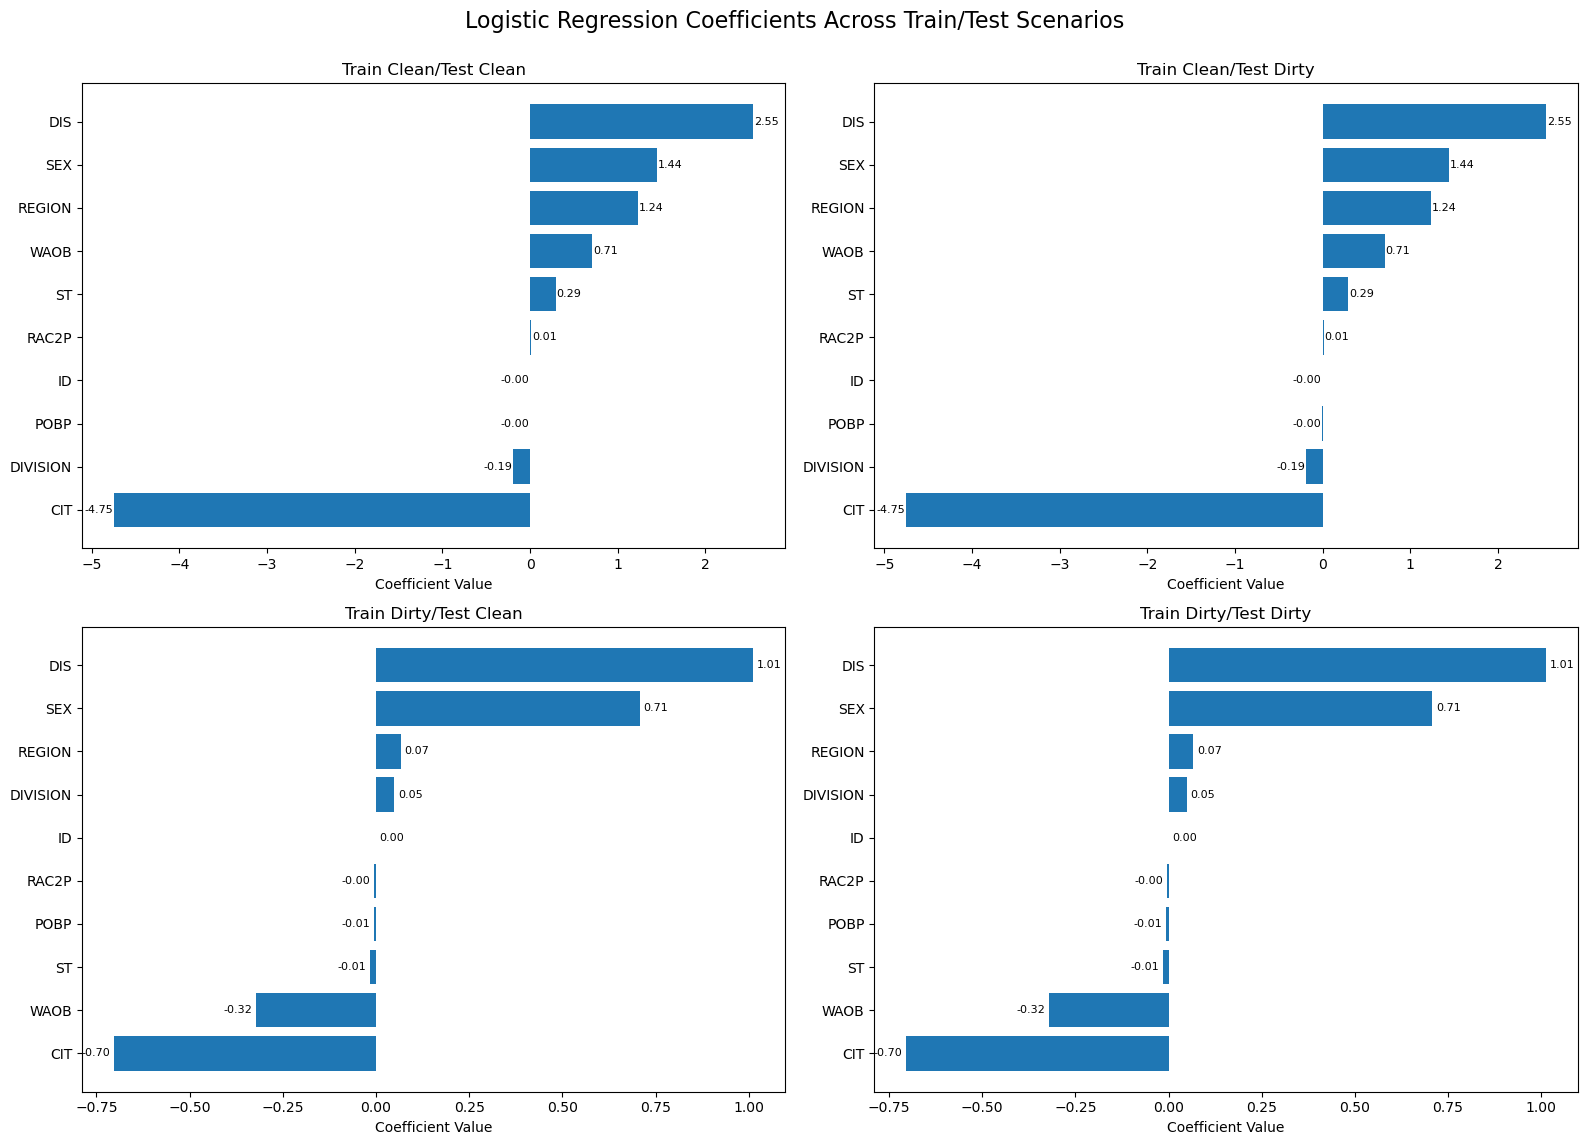

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Logistic Regression Coefficients Across Train/Test Scenarios", fontsize=16)

# Plot into each subplot
plot_logistic_coefficients(
    logreg_train_clean_test_clean, clean_feature_names, 
    "Train Clean/Test Clean", ax=axes[0, 0])

plot_logistic_coefficients(
    logreg_train_clean_test_dirty, clean_feature_names, 
    "Train Clean/Test Dirty", ax=axes[0, 1])

plot_logistic_coefficients(
    logreg_train_dirty_test_clean, dirty_feature_names, 
    "Train Dirty/Test Clean", ax=axes[1, 0])

plot_logistic_coefficients(
    logreg_train_dirty_test_dirty, dirty_feature_names, 
    "Train Dirty/Test Dirty", ax=axes[1, 1])

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig("logistic_regression_coefficients.png")
plt.show()

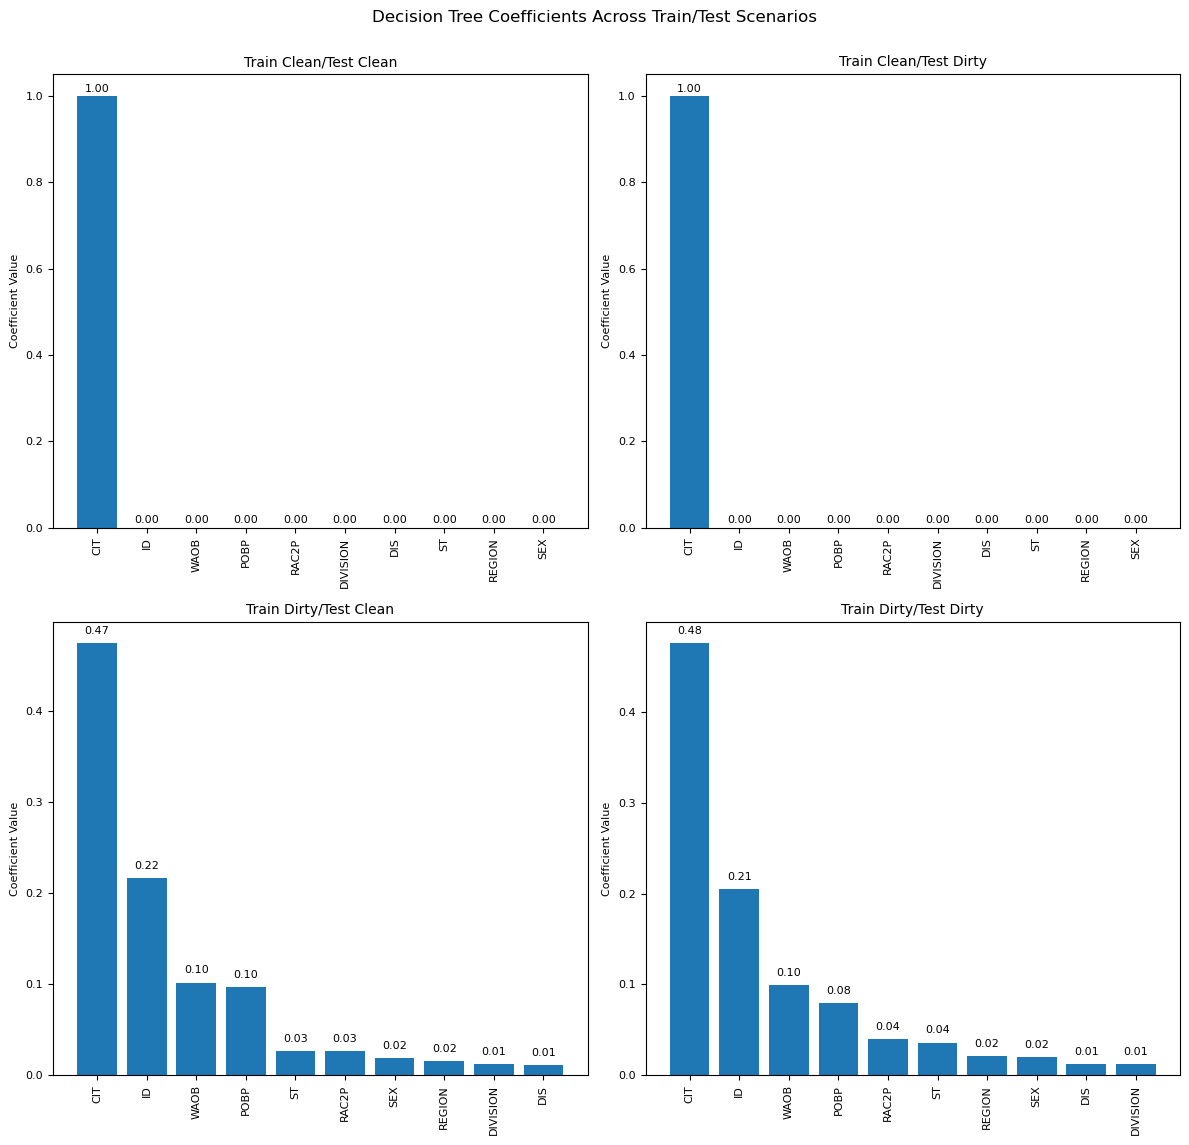

In [89]:
# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Decision Tree Coefficients Across Train/Test Scenarios", fontsize=12)

# Plotting decision tree feature importances for each scenario
tree_clean_clean_features = plot_feature_importance(
    tree_train_clean_test_clean, clean_feature_names, 
    "Train Clean/Test Clean", axs[0, 0])

tree_clean_dirty_features = plot_feature_importance(
    tree_train_clean_test_dirty, clean_feature_names, 
    "Train Clean/Test Dirty", axs[0, 1])

tree_dirty_clean_features = plot_feature_importance(
    tree_train_dirty_test_clean, dirty_feature_names, 
    "Train Dirty/Test Clean", axs[1, 0])

tree_dirty_dirty_features = plot_feature_importance(
    tree_train_dirty_test_dirty, dirty_feature_names, 
    "Train Dirty/Test Dirty", axs[1, 1])

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig("decision_tree_coefficients.png")
plt.show()

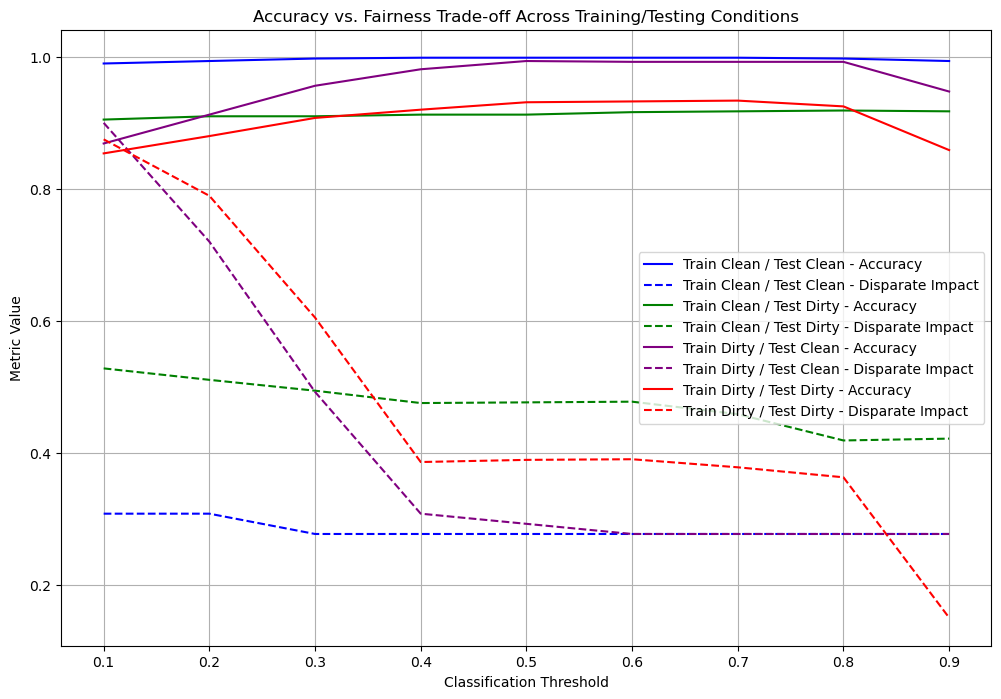

In [34]:
# Evaluate fairness metrics for different prediction thresholds
def fairness_by_threshold(model, X_test, y_test, sensitive_attr, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.1, 0.9, 9)
    
    results = {}
    
    for threshold in thresholds:
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
        
        dp = demographic_parity(y_pred, sensitive_attr)
        tpr, fpr = equalized_odds(y_test, y_pred, sensitive_attr)
        di = disparate_impact_ratio(y_pred, sensitive_attr)
        spd = statistical_parity_difference(y_pred, sensitive_attr)
        
        # Calculate accuracy at this threshold
        acc = accuracy_score(y_test, y_pred)
        
        results[threshold] = {
            'accuracy': acc,
            'demographic_parity': dp,
            'equalized_odds_tpr': tpr,
            'equalized_odds_fpr': fpr,
            'disparate_impact': di,
            'statistical_parity_diff': spd
        }
    
    return results

# Apply to all four model combinations
logreg_clean_clean_thresholds = fairness_by_threshold(logreg_train_clean_test_clean, X_test_clean, y_test_clean, s_test_clean)
logreg_clean_dirty_thresholds = fairness_by_threshold(logreg_train_clean_test_dirty, X_test_dirty, y_test_dirty, s_test_dirty)
logreg_dirty_clean_thresholds = fairness_by_threshold(logreg_train_dirty_test_clean, X_test_clean, y_test_clean, s_test_clean)
logreg_dirty_dirty_thresholds = fairness_by_threshold(logreg_train_dirty_test_dirty, X_test_dirty, y_test_dirty, s_test_dirty)

# Plot trade-offs: accuracy vs disparate impact for each
thresholds = list(logreg_clean_clean_thresholds.keys())

# Prepare metrics
clean_clean_acc = [logreg_clean_clean_thresholds[t]['accuracy'] for t in thresholds]
clean_clean_di = [logreg_clean_clean_thresholds[t]['disparate_impact'] for t in thresholds]

clean_dirty_acc = [logreg_clean_dirty_thresholds[t]['accuracy'] for t in thresholds]
clean_dirty_di = [logreg_clean_dirty_thresholds[t]['disparate_impact'] for t in thresholds]

dirty_clean_acc = [logreg_dirty_clean_thresholds[t]['accuracy'] for t in thresholds]
dirty_clean_di = [logreg_dirty_clean_thresholds[t]['disparate_impact'] for t in thresholds]

dirty_dirty_acc = [logreg_dirty_dirty_thresholds[t]['accuracy'] for t in thresholds]
dirty_dirty_di = [logreg_dirty_dirty_thresholds[t]['disparate_impact'] for t in thresholds]

# Plot
plt.figure(figsize=(12, 8))

plt.plot(thresholds, clean_clean_acc, 'b-', label='Train Clean / Test Clean - Accuracy')
plt.plot(thresholds, clean_clean_di, 'b--', label='Train Clean / Test Clean - Disparate Impact')

plt.plot(thresholds, clean_dirty_acc, 'g-', label='Train Clean / Test Dirty - Accuracy')
plt.plot(thresholds, clean_dirty_di, 'g--', label='Train Clean / Test Dirty - Disparate Impact')

plt.plot(thresholds, dirty_clean_acc, 'purple', linestyle='-', label='Train Dirty / Test Clean - Accuracy')
plt.plot(thresholds, dirty_clean_di, 'purple', linestyle='--', label='Train Dirty / Test Clean - Disparate Impact')

plt.plot(thresholds, dirty_dirty_acc, 'r-', label='Train Dirty / Test Dirty - Accuracy')
plt.plot(thresholds, dirty_dirty_di, 'r--', label='Train Dirty / Test Dirty - Disparate Impact')

plt.xlabel('Classification Threshold')
plt.ylabel('Metric Value')
plt.title('Accuracy vs. Fairness Trade-off Across Training/Testing Conditions')
plt.legend()
plt.grid(True)
plt.savefig("tradeoff.png")
plt.show()

/Users/anikamitra/anaconda3/envs/compsci527/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/anikamitra/anaconda3/envs/compsci527/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


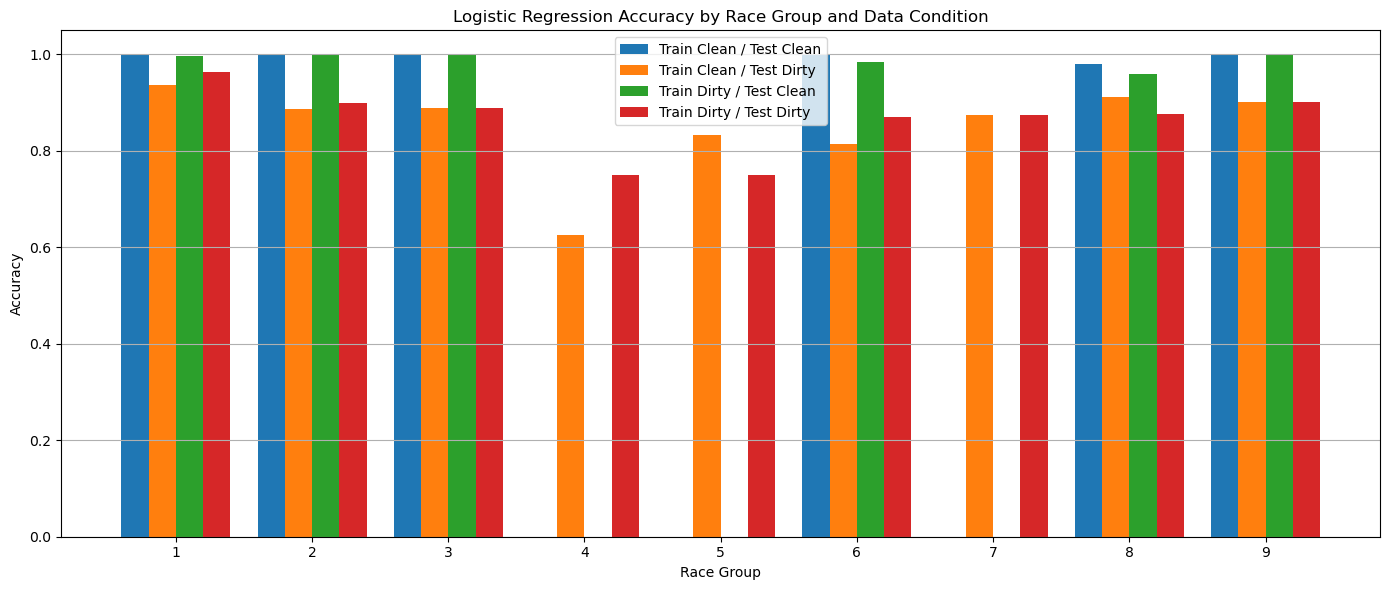

In [29]:
# Function to analyze model performance by group
# 1: White alone, 2: Black or African American alone, 3: American Indian or Alaska Native alone, 4: Chinese alone, 5: Japanese alone
# 6: Other Asian or Pacific Islander alone, 7: Other race alone, 8: Two or more races, 9: Asian Indian alone
def analyze_by_group(y_true, y_pred, sensitive_attr):
    groups = sensitive_attr.unique()
    results = {}
    
    for group in groups:
        mask = (sensitive_attr == group)
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        
        if len(y_true_group) < 5:
            continue
        
        results[group] = {
            'accuracy': accuracy_score(y_true_group, y_pred_group),
            'group_size': len(y_true_group),
            'percent_positive_predictions': y_pred_group.mean() * 100,
            'percent_positive_actual': y_true_group.mean() * 100,
            'confusion_matrix': confusion_matrix(y_true_group, y_pred_group).tolist()
        }
    
    return results

# Evaluate predictions from each model configuration
logreg_clean_clean_by_group = analyze_by_group(y_test_clean, y_pred_logreg_train_clean_test_clean, s_test_clean)
logreg_clean_dirty_by_group = analyze_by_group(y_test_dirty, y_pred_logreg_train_clean_test_dirty, s_test_dirty)
logreg_dirty_clean_by_group = analyze_by_group(y_test_clean, y_pred_logreg_train_dirty_test_clean, s_test_clean)
logreg_dirty_dirty_by_group = analyze_by_group(y_test_dirty, y_pred_logreg_train_dirty_test_dirty, s_test_dirty)

# Collect all group names
groups = sorted(set(logreg_clean_clean_by_group.keys()) |
                set(logreg_clean_dirty_by_group.keys()) |
                set(logreg_dirty_clean_by_group.keys()) |
                set(logreg_dirty_dirty_by_group.keys()))

# Extract accuracy by group for each configuration
clean_clean_acc = [logreg_clean_clean_by_group.get(g, {}).get('accuracy', 0) for g in groups]
clean_dirty_acc = [logreg_clean_dirty_by_group.get(g, {}).get('accuracy', 0) for g in groups]
dirty_clean_acc = [logreg_dirty_clean_by_group.get(g, {}).get('accuracy', 0) for g in groups]
dirty_dirty_acc = [logreg_dirty_dirty_by_group.get(g, {}).get('accuracy', 0) for g in groups]

# Plot
x = np.arange(len(groups))
width = 0.2

plt.figure(figsize=(14, 6))
plt.bar(x - 1.5*width, clean_clean_acc, width, label='Train Clean / Test Clean')
plt.bar(x - 0.5*width, clean_dirty_acc, width, label='Train Clean / Test Dirty')
plt.bar(x + 0.5*width, dirty_clean_acc, width, label='Train Dirty / Test Clean')
plt.bar(x + 1.5*width, dirty_dirty_acc, width, label='Train Dirty / Test Dirty')

plt.xlabel('Race Group')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy by Race Group and Data Condition')
plt.xticks(x, groups)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

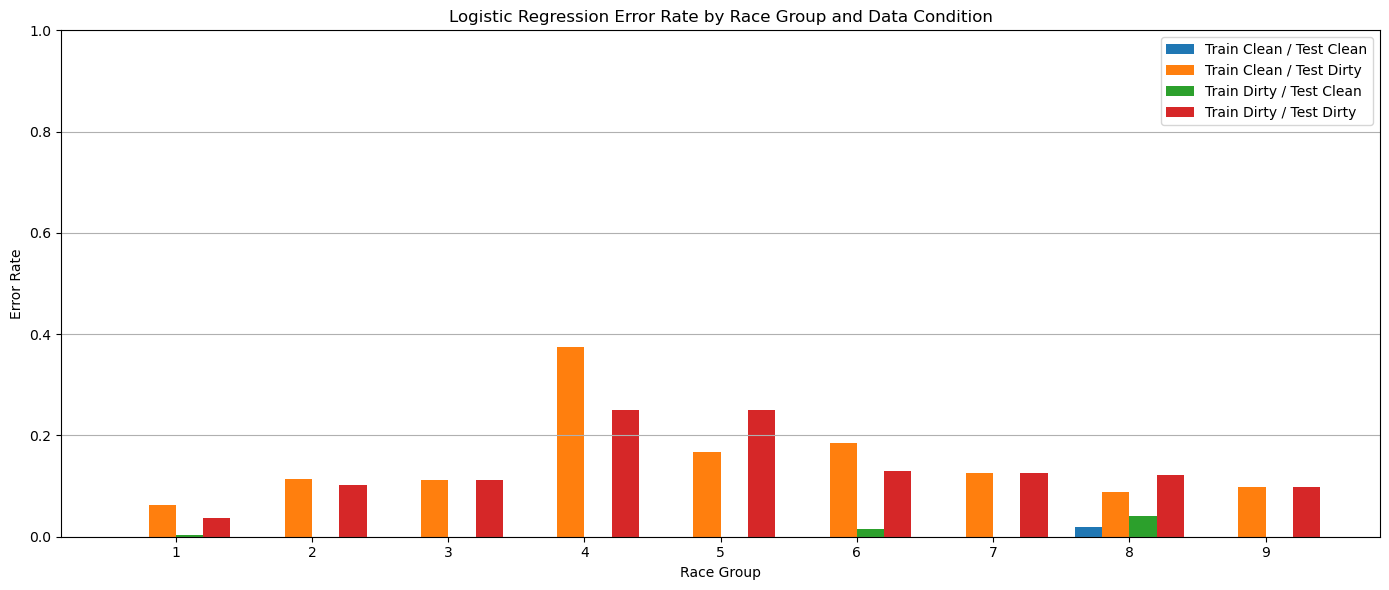

In [33]:
# Function to identify and analyze misclassified examples
def analyze_misclassifications(X_test, y_test, y_pred, sensitive_attr):
    misclassified = (y_test != y_pred)
    X_misclassified = X_test[misclassified]
    y_true_misclassified = y_test[misclassified]
    s_misclassified = sensitive_attr[misclassified]
    
    group_counts = s_misclassified.value_counts().to_dict()
    total_by_group = sensitive_attr.value_counts().to_dict()
    
    error_rates = {g: group_counts.get(g, 0) / total_by_group.get(g, 1) for g in total_by_group}
    
    misclassified_stats = X_misclassified.describe()
    overall_stats = X_test.describe()
    
    return {
        'total_misclassified': misclassified.sum(),
        'error_rate': misclassified.mean(),
        'group_error_counts': group_counts,
        'group_error_rates': error_rates,
        'misclassified_feature_stats': misclassified_stats,
        'overall_feature_stats': overall_stats
    }

# Analyze all four logistic regression scenarios
logreg_clean_clean_errors = analyze_misclassifications(X_test_clean, y_test_clean, y_pred_logreg_train_clean_test_clean, s_test_clean)
logreg_clean_dirty_errors = analyze_misclassifications(X_test_dirty, y_test_dirty, y_pred_logreg_train_clean_test_dirty, s_test_dirty)
logreg_dirty_clean_errors = analyze_misclassifications(X_test_clean, y_test_clean, y_pred_logreg_train_dirty_test_clean, s_test_clean)
logreg_dirty_dirty_errors = analyze_misclassifications(X_test_dirty, y_test_dirty, y_pred_logreg_train_dirty_test_dirty, s_test_dirty)

# Collect all race groups
groups = sorted(set(logreg_clean_clean_errors['group_error_rates'].keys()) |
                set(logreg_clean_dirty_errors['group_error_rates'].keys()) |
                set(logreg_dirty_clean_errors['group_error_rates'].keys()) |
                set(logreg_dirty_dirty_errors['group_error_rates'].keys()))

# Extract error rates by group
clean_clean_errors = [logreg_clean_clean_errors['group_error_rates'].get(g, 0) for g in groups]
clean_dirty_errors = [logreg_clean_dirty_errors['group_error_rates'].get(g, 0) for g in groups]
dirty_clean_errors = [logreg_dirty_clean_errors['group_error_rates'].get(g, 0) for g in groups]
dirty_dirty_errors = [logreg_dirty_dirty_errors['group_error_rates'].get(g, 0) for g in groups]

# Plot grouped bar chart
x = np.arange(len(groups))
width = 0.2

plt.figure(figsize=(14, 6))
plt.bar(x - 1.5*width, clean_clean_errors, width, label='Train Clean / Test Clean')
plt.bar(x - 0.5*width, clean_dirty_errors, width, label='Train Clean / Test Dirty')
plt.bar(x + 0.5*width, dirty_clean_errors, width, label='Train Dirty / Test Clean')
plt.bar(x + 1.5*width, dirty_dirty_errors, width, label='Train Dirty / Test Dirty')

plt.xlabel('Race Group')
plt.ylabel('Error Rate')
plt.title('Logistic Regression Error Rate by Race Group and Data Condition')
plt.xticks(x, groups)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig("error_rate_by_race.png")
plt.show()